<a href="https://colab.research.google.com/github/YasuharuSuzuki/25_programing2/blob/main/" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Section 14 
# レストランのチップ額予測

## scikit-learn
<img src="https://raw.githubusercontent.com/scikit-learn/scikit-learn/main/doc/logos/scikit-learn-logo.png">

- 前回の授業ではワインの種類やあやめの品種を学習・予測する「分類モデル」を作成しました。
- 今回の授業では引き続きscikit-learnを使用して、数値予測を行う「回帰モデル」を作成してみましょう。

## サンプルプログラム1　レストランのチップ額予測を行う

### ライブラリのインストール

In [ ]:
# matplotlib日本語対応ライブラリのインストール
!pip install japanize_matplotlib

### GoogleDrive の Mount

In [ ]:
# drive.mount()を使用してGoogleDriveをMount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# os.chdir()を使用してカレントディレクトリを変更。作成したショーットカット名を使ってパスを指定します。
import os
os.chdir('/content/drive/MyDrive/＜作成したショートカット名＞')

### ライブラリのimport

In [1]:
import numpy as np # 数値演算ライブラリ
import pandas as pd # データ分析ライブラリ
import matplotlib.pyplot as plt # 可視化ライブラリ
import seaborn as sns # 可視化ライブラリ
from sklearn.preprocessing import LabelEncoder # 文字データを数字に置換するクラス（後述）
from sklearn.model_selection import train_test_split # scikit-learnの訓練データ / テストデータ 分割関数
from sklearn import linear_model # scikit-learnのlinear_modelライブラリ
from sklearn.ensemble import RandomForestRegressor  # RandomForestRegressor (回帰モデル)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # 回帰モデルの性能評価用関数

### 定数の定義
- データファイルパスを定義しておきます
- データ読み込みの際にご使用してください。修正は不要です

In [2]:
# データファイルパス定義
TIPS_CSV = "./data/tips_customized.csv"

### サンプルプログラム1-1　レストランのチップ額のデータセットを読み込む

In [3]:
# データセットを読み込み
df_tips = pd.read_csv(TIPS_CSV, index_col=0) # 0番の列をindexに使用するため、index_col=0を指定します

### サンプルプログラム1-2　読み込んだDataFrameを確認

#### 先頭５行のデータをざっと眺める

In [4]:
df_tips.head()

,total_bill,sex,smoker,day,time,size,tip
0,16.99,Female,No,Sun,Dinner,2,1.01
1,10.34,Male,No,Sun,Dinner,3,1.66
2,21.01,Male,No,Sun,Dinner,3,3.50
3,23.68,Male,No,Sun,Dinner,2,3.31
4,24.59,Female,No,Sun,Dinner,4,3.61


- これまでと違ってMale/Femaleなどの文字列が含まれています。

| カラム名 | 内容 |
| --- | --- |
| total_bill | 総支払額(食事代、税込み)　(USドル) |
| sex | 性別 |
| smoker | 喫煙者か否か |
| day | 曜日 |
| time | 食事の時間 |
| size | 人数 |

In [5]:
df_tips['sex'].value_counts()

sex
Male      157
Female     87
Name: count, dtype: int64

- 性別は男性/女性のみ

In [6]:
df_tips['smoker'].value_counts()

smoker
No     146
Yes     88
Name: count, dtype: int64

- 喫煙者かどうかも２値のみです

In [7]:
df_tips['day'].value_counts()

day
Sat     87
Sun     76
Thur    62
Fri     19
Name: count, dtype: int64

- dayには曜日が入っていて、木曜日、金曜日、土曜日、日曜日のみが入っています（月曜日～水曜日は存在しない）

In [8]:
df_tips['time'].value_counts()

time
Dinner    176
Lunch      68
Name: count, dtype: int64

- dinnerが多い

##### カテゴリカル変数
- 特定のグループまたは名目上のカテゴリに、いくつかの質的特性に基づいて値を割り当てた変数のことをカテゴリカル変数と言います。
- 質的変数とも言います。
- 上記のsex, smoker, dayはそれぞれカテゴリカル変数と言えます。
- SVRやRandomForestRegressorのような回帰モデルにカテゴリ変数を指定するとエラーが発生するので対策が必要です。（後ほど扱います）

### 行数、列数、データ型、欠損値の確認

In [9]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   sex         244 non-null    object 
 2   smoker      234 non-null    object 
 3   day         244 non-null    object 
 4   time        244 non-null    object 
 5   size        244 non-null    int64  
 6   tip         244 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


- smoker の変数が欠損しています

##### 欠損値
- データセット内のある変数がなんらかの理由によりデータが欠落しているものを刺します。
- 例えばアンケート調査で無回答だった場合や、センサーデータで取得に失敗したデータなどが該当します。
- モデルに欠損値が含まれたデータを指定するとエラーが発生するため、対策が必要です。（後ほど扱います）

### 基本統計量の確認

In [10]:
df_tips.describe()

,total_bill,size,tip
count,244.000000,244.000000,244.000000
mean,19.785943,2.569672,2.998279
std,8.902412,0.951100,1.383638
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.000000,2.900000
75%,24.127500,3.000000,3.562500
max,50.810000,6.000000,10.000000


- total_billおよびtipでは、75%タイルからmax値に大きな開きが発生しており、外れ値か、べき分布のデータであることが考えられます。

### サンプルプログラム1-3　欠損値の対策

In [11]:
# 欠損値の数を確認
# isnull()という関数を使用して欠損値かどうかを取得し、sum()関数を用いて集計することが可能です
df_tips.isnull().sum()

total_bill     0
sex            0
smoker        10
day            0
time           0
size           0
tip            0
dtype: int64

- smoker 列に10件のみ存在するようです
- 量としては多くないので、そのまま削除しても良さそうです

In [12]:
# 欠損値を持つ行を確認
# any()関数を用いると欠損行を抽出できます
df_tips[df_tips.isnull().any(axis=1)]

,total_bill,sex,smoker,day,time,size,tip
9,14.78,Male,NaN,Sun,Dinner,2,3.23
40,16.04,Male,NaN,Sat,Dinner,3,2.24
106,20.49,Male,NaN,Sat,Dinner,2,4.06
140,17.47,Female,NaN,Thur,Lunch,2,3.50
153,24.55,Male,NaN,Sun,Dinner,4,2.00
171,15.81,Male,NaN,Sat,Dinner,2,3.16
174,16.82,Male,NaN,Sun,Dinner,2,4.00
186,20.90,Female,NaN,Sun,Dinner,3,3.50
215,12.90,Female,NaN,Sat,Dinner,2,1.10
242,17.82,Male,NaN,Sat,Dinner,2,1.75


- 目的変数であるtip値を確認。2σ以上の値になっていないため、削除しても影響は少なめと思われる。
- Dinnerが多いが、元々Dinnerの方が多めのため、それほど影響は無さそう

In [13]:
# 欠損値の削除
# dropna()メソッドを使用して欠損値を削除する
df_tips2 = df_tips.dropna(how='any')  # how='any'は全ての列のうちどれか１つでも欠損値を含む行を対象とすることを指定しています
df_tips2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  234 non-null    float64
 1   sex         234 non-null    object 
 2   smoker      234 non-null    object 
 3   day         234 non-null    object 
 4   time        234 non-null    object 
 5   size        234 non-null    int64  
 6   tip         234 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 14.6+ KB


- 欠損値を削除した。
- ちなみに削除する以外の方法としては、欠損値を予測するモデルを作り、値を埋めて活かす方法も存在する

### サンプルプログラム1-4　カテゴリカル変数の対策

In [14]:
categories = ['sex','smoker','day','time']  # カテゴリカル変数の対象とする列を指定する

df_tips3 = df_tips2.copy()  # DataFrameを書き換えるため、変換する
for category in categories:
    label_encoder = LabelEncoder()  # 文字列を数値に変換するクラスのインスタンスを作成
    label_encoder = label_encoder.fit(df_tips3[category])  # fit関数で文字列と数値の関係を取得
    df_tips3[category] = label_encoder.transform(df_tips3[category])  # transformで変換を実行
    df_tips3[category] = df_tips3[category].astype('category') # カテゴリカル変数には専用の型'category'があるため、型変換しておく
    print(df_tips3[category].value_counts())  # 変換後の値を表示

df_tips3.info()  # 型を表示

sex
1    150
0     84
Name: count, dtype: int64
smoker
0    146
1     88
Name: count, dtype: int64
day
1    82
2    72
3    61
0    19
Name: count, dtype: int64
time
0    167
1     67
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  234 non-null    float64 
 1   sex         234 non-null    category
 2   smoker      234 non-null    category
 3   day         234 non-null    category
 4   time        234 non-null    category
 5   size        234 non-null    int64   
 6   tip         234 non-null    float64 
dtypes: category(4), float64(2), int64(1)
memory usage: 8.8 KB


- object型（文字列）が無くなり、categoryになった

### サンプルプログラム1-5　相関係数の表示

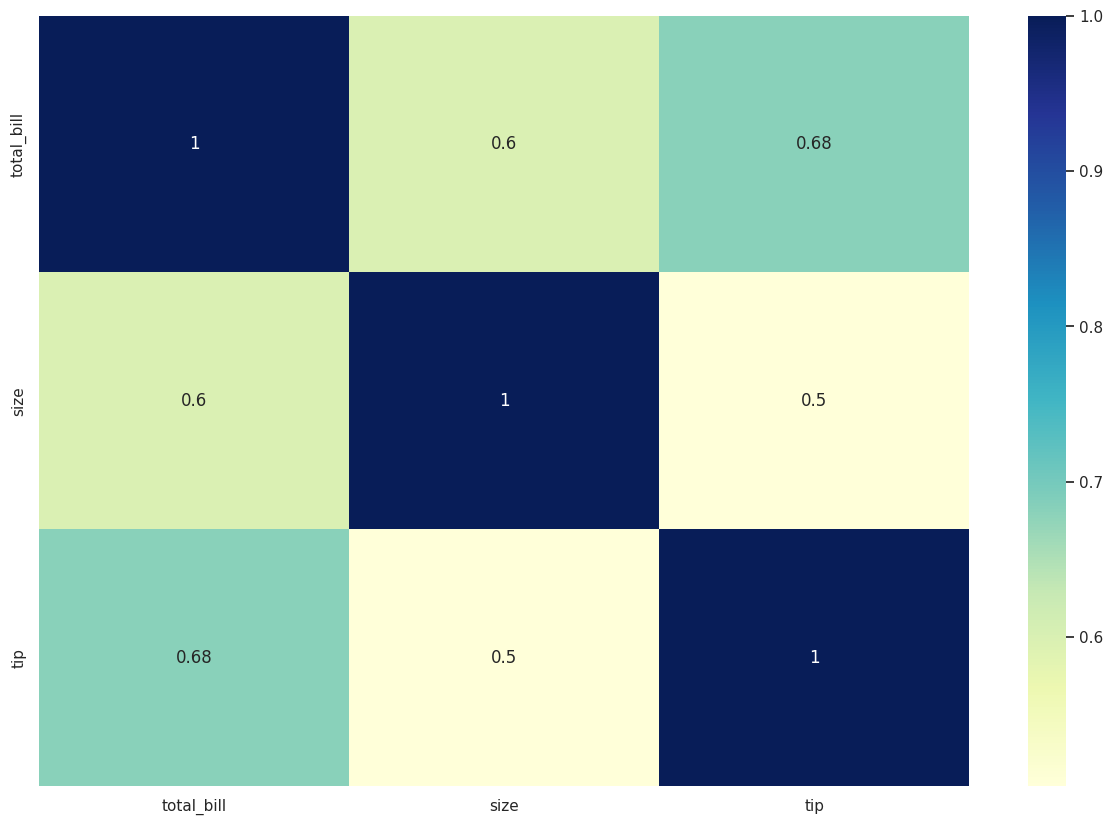

In [15]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df_tips3.loc[:,['total_bill','size','tip']].corr(), annot=True, cmap="YlGnBu") # カテゴリカル変数は除いて表示
plt.show()

### 考察
- ある程度強い相関はあるものの、かなり強い相関とまでは言えないぐらいの相関。
- total_billにtipが影響するのも理解できるし、size(人数)がtotal_billに影響するのも理解できるため、ある程度納得の行く結果と言える。

### サンプルプログラム1-6　ヒストグラムの表示

<Axes: >

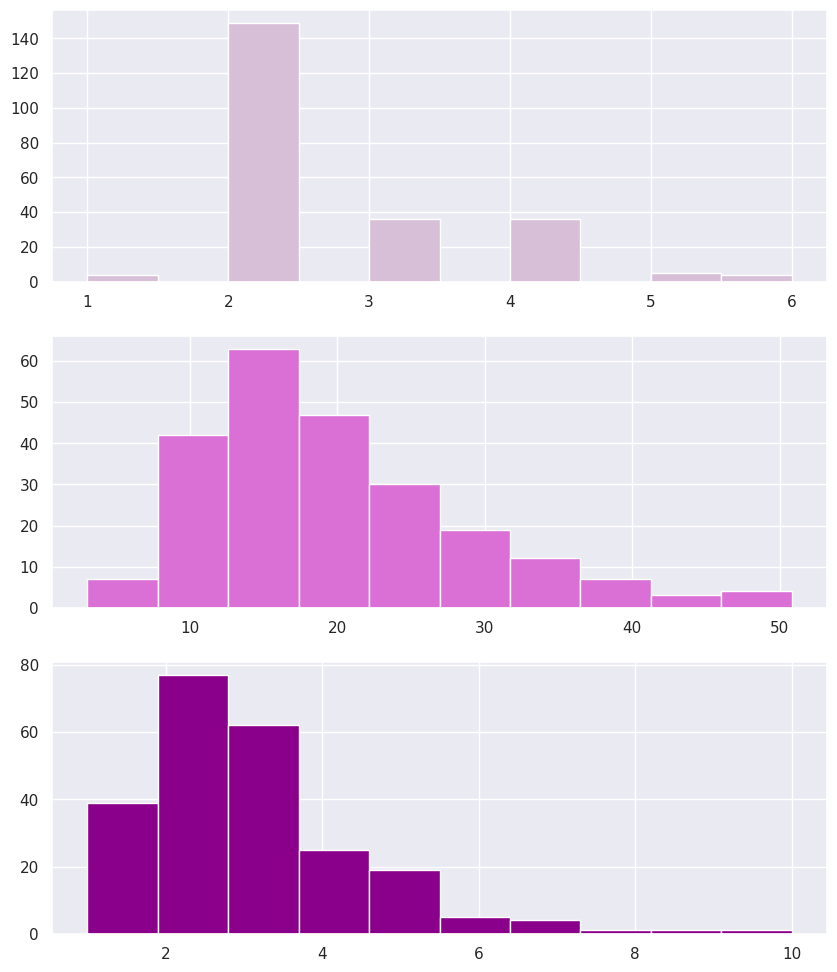

In [16]:
# ヒストグラムの表示
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
df_tips3['size'].hist(color='thistle', ax=axes[0])
df_tips3['total_bill'].hist(color='orchid', ax=axes[1])
df_tips3['tip'].hist(color='darkmagenta', ax=axes[2])

### 考察
- べき分布ですね
- 裾野が広い分布のため、正規分布と仮定して外れ値を除去するのは辞めておいたほうが良さそうです

### サンプルプログラム1-7　多変量連関図の表示

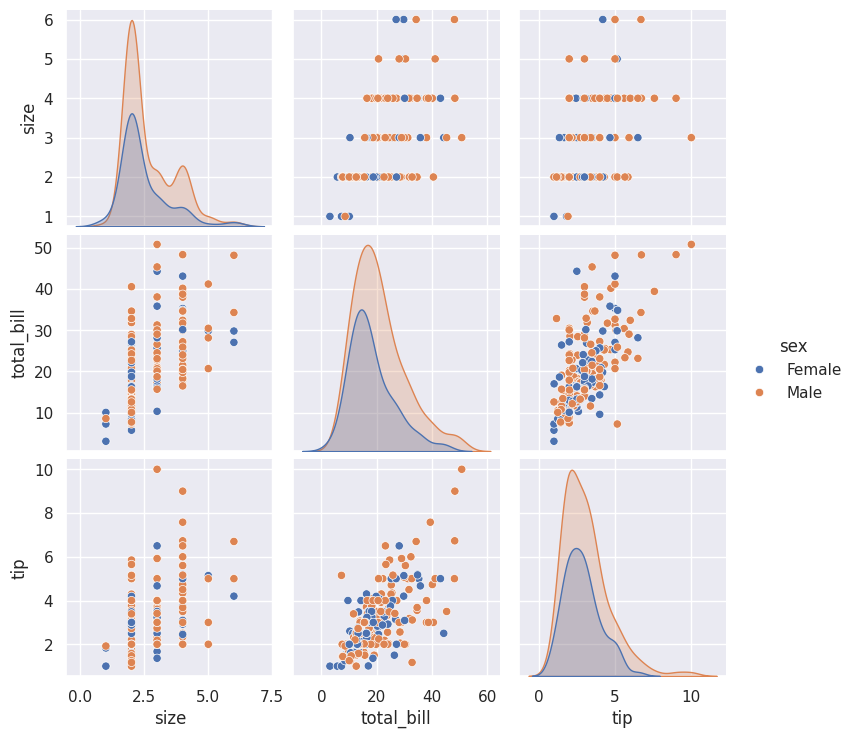

In [17]:
# 性別で層別してplot
sns.pairplot(df_tips2[['size','total_bill','tip','sex']], hue='sex')

### 考察
- 男性の4名の支払い数がやや特徴的な分布あり
  - 家族で来ている時に支払いを男性が行っているケースが多いのかも

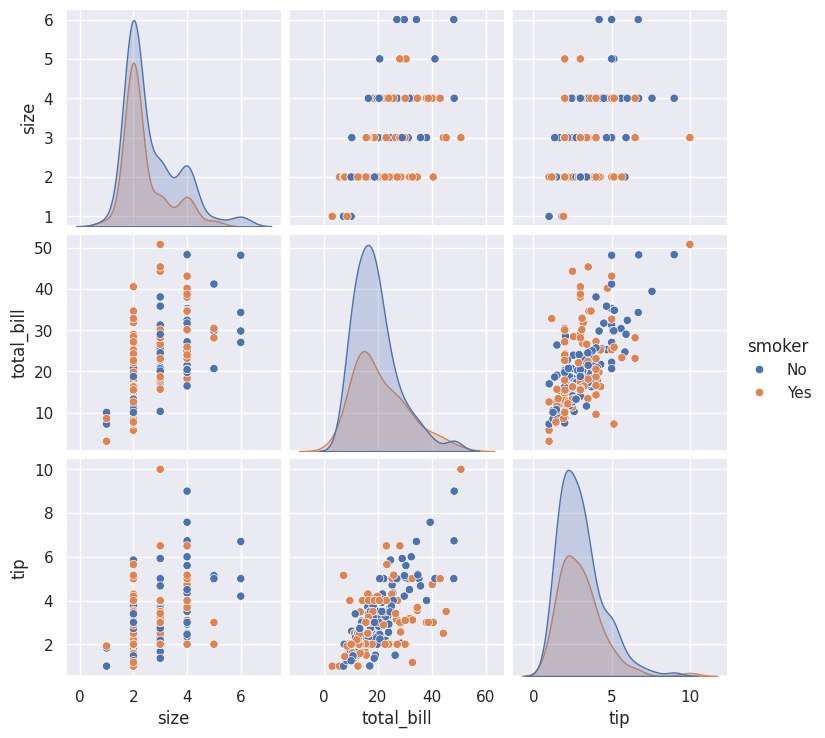

In [18]:
# 喫煙者かどうかで層別してplot
sns.pairplot(df_tips2[['size','total_bill','tip','smoker']], hue='smoker')

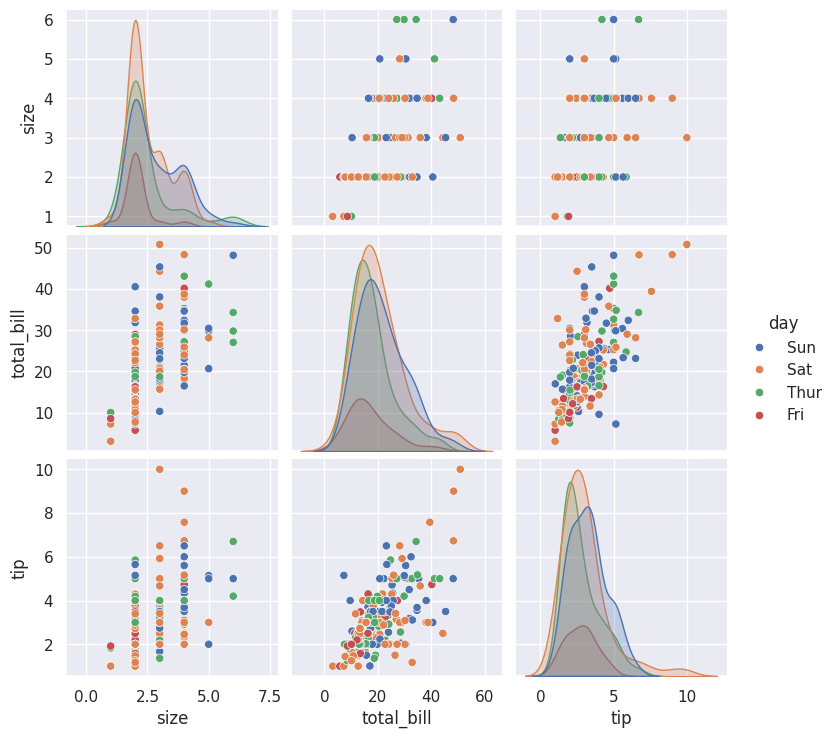

In [19]:
# 曜日で層別してplot
sns.pairplot(df_tips2[['size','total_bill','tip','day']], hue='day')

### 考察
- 週末かどうかでsize(人数)にやや違いが見られる。

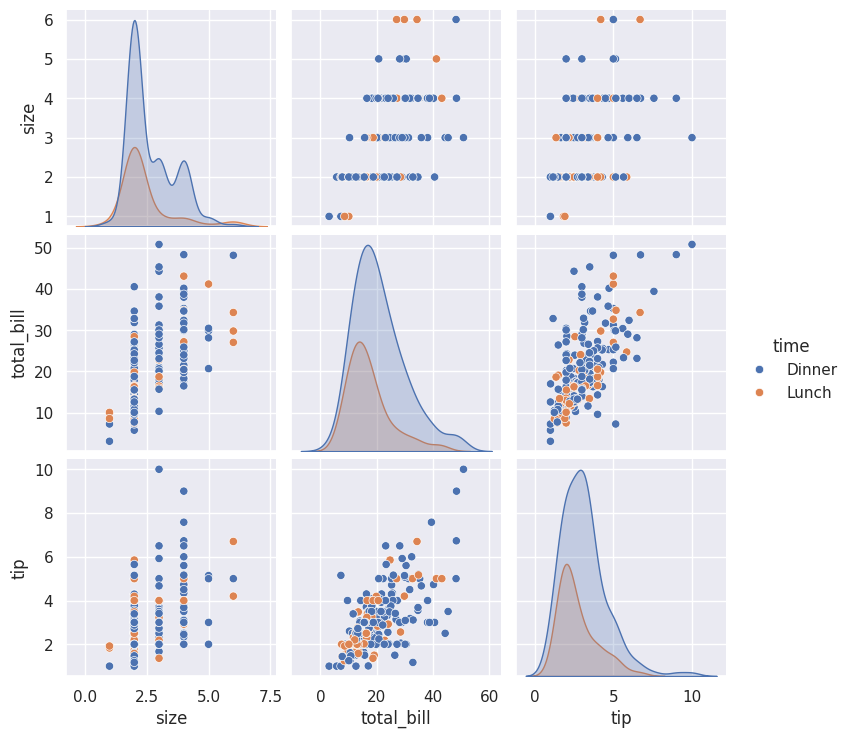

In [20]:
# 昼間か夜かで層別してplot
sns.pairplot(df_tips2[['size','total_bill','tip','time']], hue='time')

### 考察
- sizeは夜間に4人での来店数が多めになる分布が見える
- tipは夜間の方がやや多め

### サンプルプログラム1-8　回帰モデルを作る(LinearRegression)

In [21]:
# 説明変数と目的変数に分ける
X = df_tips3.iloc[:,:-1]
y = df_tips3.iloc[:,-1]

# 訓練データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# LinearRegressionで学習させる
ln_model = linear_model.LinearRegression()    # 回帰モデルを作る
ln_model.fit(X_train, y_train)    # 訓練する

LinearRegression()

### サンプルプログラム1-9　エラーレートと決定係数によるモデルの評価(LinearRegression)

- 各種エラーレートと決定係数の数式は以下の通りです
### Mean Absolute Error (MAE)
$$
MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

### Mean Squared Error (MSE)
$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

### Root Mean Squared Error (RMSE)
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

### 決定係数 (R^2)
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

ここで、

- $n$ はサンプル数
- $y_i$ は実際の値
- $\hat{y}_i$ は予測値
- $\bar{y}$ は $y$ の平均値

です。


In [23]:
# エラーレートと決定係数の算出を行うユーザー定義関数
def evaluate_metrics(y_train_pred, y_test_pred):
    # 学習時スコア
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    train_MSE = mean_squared_error(y_train, y_train_pred)
    train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_R2 = r2_score(y_train, y_train_pred)
    
    # テスト時スコア
    test_MAE = mean_absolute_error(y_test, y_test_pred)
    test_MSE = mean_squared_error(y_test, y_test_pred)
    test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_R2 = r2_score(y_test, y_test_pred)
    
    print("学習時スコア(train score)")
    print("　平均絶対誤差: ", train_MAE)
    print("　平均二乗誤差: ", train_MSE)
    print("　二乗平均平方根誤差: ", train_RMSE)
    print("　決定係数R^2: ", train_R2)
    
    print("テストスコア(test score)")
    print("　平均絶対誤差: ", test_MAE)
    print("　平均二乗誤差: ", test_MSE)
    print("　二乗平均平方根誤差: ", test_RMSE)
    print("　決定係数R^2: ", test_R2)

In [24]:
y_train_pred = ln_model.predict(X_train)  # 学習データを使って推論する
y_test_pred = ln_model.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

学習時スコア(train score)
　平均絶対誤差:  0.7319052569583733
　平均二乗誤差:  1.0623727913527168
　二乗平均平方根誤差:  1.0307146992998193
　決定係数R^2:  0.4780470886453463
テストスコア(test score)
　平均絶対誤差:  0.737690402435345
　平均二乗誤差:  0.9399580751937852
　二乗平均平方根誤差:  0.9695143501742433
　決定係数R^2:  0.4567211581365074


### サンプルプログラム1-10　残差の可視化によるモデル評価(LinearRegression)
- 残差とは実際の値と回帰モデルによる予測値との差のことです
- ここではX軸を実際の値、y軸を予測値とし、残差0の直線を引いてどの程度実際の値と予測値でズレがあるのかを可視化します

In [25]:
# 残差の可視化を行うユーザー定義関数
def residual_plot(y_train_pred, y_test_pred):
    df_train = pd.DataFrame(y_train)
    df_train['y_train_pred'] = y_train_pred
    
    df_test = pd.DataFrame(y_test)
    df_test['y_test_pred'] = y_test_pred
    
    ax = plt.gca()
    
    # 傾き1の直線を追加
    a_line=[min(df_train['tip'].min(), df_test['tip'].min()), max(df_train['tip'].max(), df_test['tip'].max())]
    sns.regplot(x=df_train['tip'], y=df_train['y_train_pred'],label='train')
    sns.regplot(x=df_test['tip'], y=df_test['y_test_pred'],label='test')
    sns.regplot(x=a_line, y=a_line,ci=None, scatter=False, line_kws={'color': 'orange', 'linestyle': '--', 'lw': 1},label='residual 0')
    
    ax.set_xlabel('true')
    ax.set_ylabel('pred')
    
    plt.legend(fontsize=10)
    plt.show()

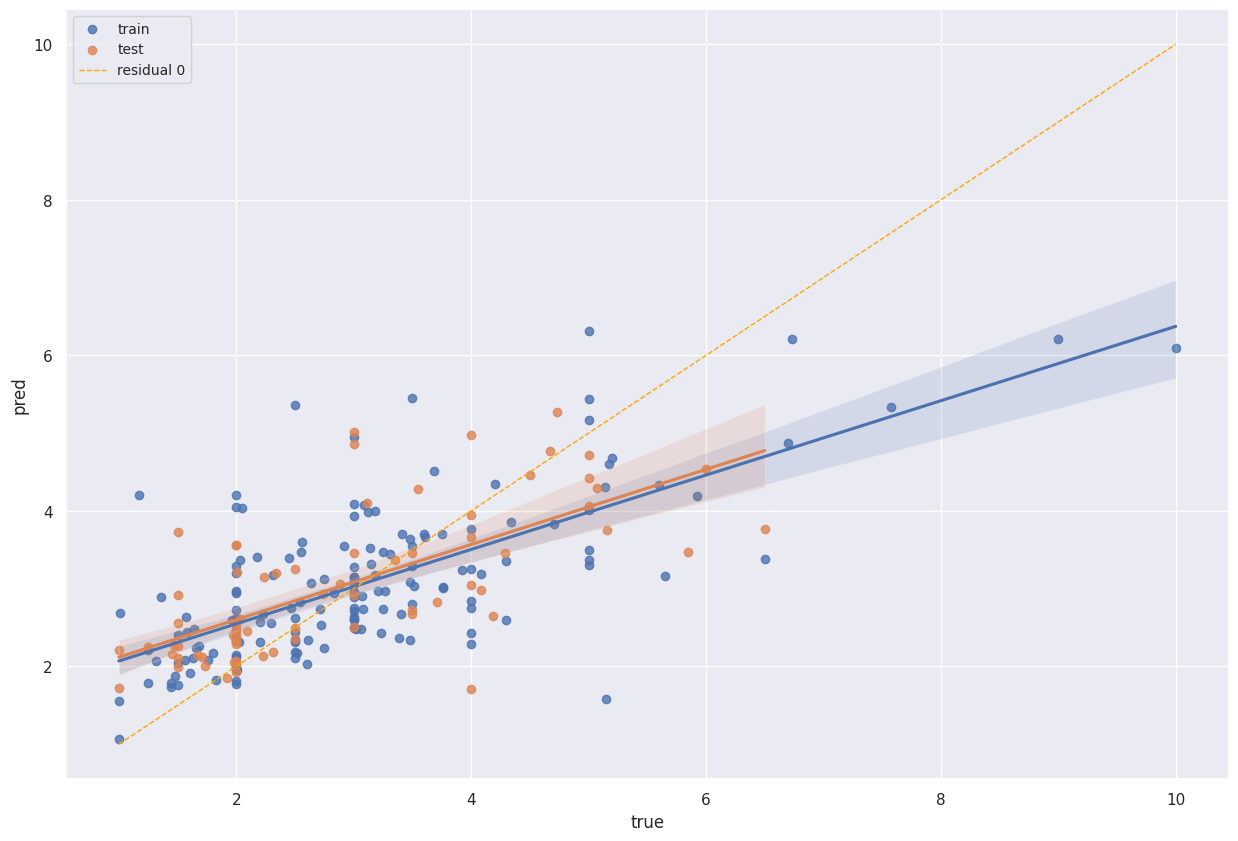

In [26]:
# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- tip値の大きな学習データが疎らに分布しており、わずかなデータ量の増減によって大きく影響が出そうである
  - \\$10 や \\$9 の学習データは比較的残差０の直線に近いが、\\$6～\\$7.5あたりの残差が大きく、データ量不足が伺える
  - この差はデータ量を増やさないと難しいように思う
- 学習とテストではあまり差異が発生していない
  - テストの残差は学習時と同様の傾向となっており、それほど過学習はしていないように見える

### サンプルプログラム1-11　回帰モデルを作る(RandomForestRegressor)

In [27]:
# 学習する
rf_model = RandomForestRegressor(max_depth=3)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

### サンプルプログラム1-12 エラーレートと決定係数によるモデルの評価(RandomForestRegressor)

In [28]:
y_train_pred = rf_model.predict(X_train)  # 学習データを使って推論する
y_test_pred = rf_model.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

学習時スコア(train score)
　平均絶対誤差:  0.6347792918755883
　平均二乗誤差:  0.7281044905408431
　二乗平均平方根誤差:  0.8532903905124228
　決定係数R^2:  0.6422759866390302
テストスコア(test score)
　平均絶対誤差:  0.6754962891331863
　平均二乗誤差:  0.8526450888123379
　二乗平均平方根誤差:  0.9233878322851877
　決定係数R^2:  0.507186492041082


### 考察
- エラーレート（MAE、MSE、RMSE）は概ね学習時の方が低く、テスト時の方が高いため過学習は起きていないように見える
- 決定係数は学習時のほうが高い点も同様
- 事前に調べた相関係数と比べても決定係数が高め。データは多くない状況のため、少しデータが変わっただけでも大きく変動しそう。
  - たまたま学習データとテストデータの分布が似ていた可能性も高い。

### サンプルプログラム1-13　残差の可視化によるモデル評価(RandomForestRegressor)

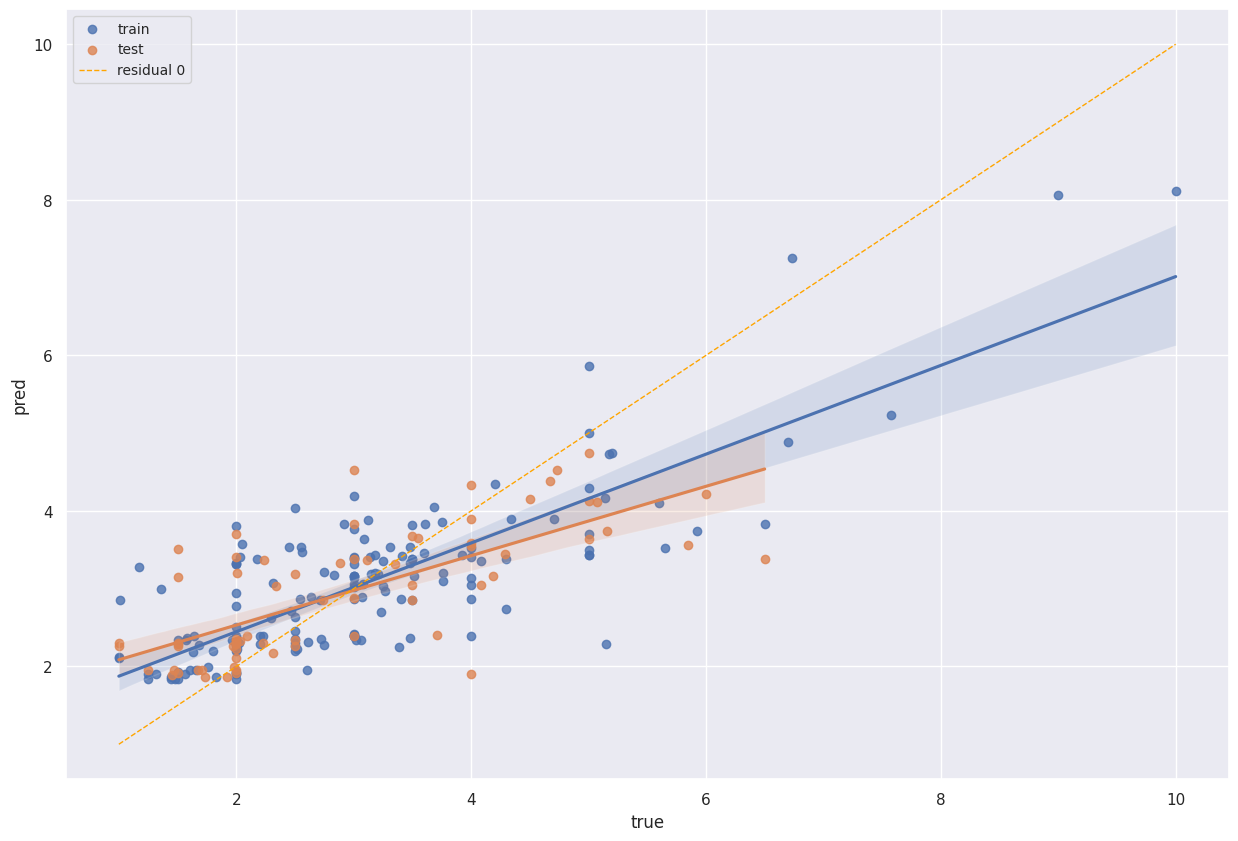

In [29]:
# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- RandomForestRegressor では、学習時とテスト時で精度の落ち幅がすこし大きくなっている
  - データが足りない中でも比較的良好なモデルが作成できているようにも思える

---
---
---
---
---